In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
Successfully built gast termcolor wrapt absl-py


ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.16.4)


In [3]:
# Use CPU only
# Only Macbook needs to run this cell
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [22]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization

## Load data and do data normalization

In [3]:
df = pd.read_csv('Options_R.csv')
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,volatility,underlying_price,interest_rate,cp_flag_C,cp_flag_P
0,AXP,2013-01-02,2013-01-04,2,40.0,20.4,0.170513,58.75,0.0008,1,0
1,AXP,2013-01-02,2013-01-04,2,44.0,15.4,0.170513,58.75,0.0008,1,0
2,AXP,2013-01-02,2013-01-04,2,45.0,14.4,0.170513,58.75,0.0008,1,0
3,AXP,2013-01-02,2013-01-04,2,46.0,13.4,0.170513,58.75,0.0008,1,0
4,AXP,2013-01-02,2013-01-04,2,47.0,12.4,0.170513,58.75,0.0008,1,0


In [4]:
df = df[df['volatility'].notnull()]
y = df['best_offer'].values
X = df[['maturity', 'strike_price', 'underlying_price', 'volatility', 'cp_flag_C', 'cp_flag_P', 'interest_rate']]

In [5]:
# Normalize the data to build a regression neural network model
sc= preprocessing.MinMaxScaler()
X= sc.fit_transform(X)
#y= y.reshape(-1,1)
#y=sc.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape)
print(y_train.shape)

(1079819, 7)
(1079819,)


In [8]:
XX_train, XX_validation, yy_train, yy_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Build a keras Sequential model

In [9]:
# Built Keras sequential model with 3 hidden layer, and after the first hidden layer.
model = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

W0706 18:52:14.825369  3468 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 18:52:14.841377  3468 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 18:52:14.845366  3468 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [10]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

In [11]:
# Because it is a simple regression problem, we should custom metrics function
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [12]:
# use mean_squared_error to compile regression model loss
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)

W0706 18:52:24.525656  3468 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
# fit the model
result = model.fit(XX_train, 
                   yy_train,
                   epochs = 100,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0706 18:52:32.725258  3468 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0706 18:52:32.816236  3468 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 863855 samples, validate on 215964 samples
Epoch 1/100
863855/863855 [==============================] - 4s 5us/step - loss: 16.7139 - rmse: 1.2588 - r_square: 0.9368 - val_loss: 0.3919 - val_rmse: 0.4234 - val_r_square: 0.9985
Epoch 2/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.3667 - rmse: 0.3963 - r_square: 0.9985 - val_loss: 0.3103 - val_rmse: 0.3537 - val_r_square: 0.9988
Epoch 3/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.3330 - rmse: 0.3758 - r_square: 0.9987 - val_loss: 0.4859 - val_rmse: 0.4964 - val_r_square: 0.9981
Epoch 4/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.3113 - rmse: 0.3626 - r_square: 0.9988 - val_loss: 0.3155 - val_rmse: 0.3853 - val_r_square: 0.9988
Epoch 5/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.2997 - rmse: 0.3547 - r_square: 0.9988 - val_loss: 0.2917 - val_rmse: 0.3371 - val_r_square: 0.9988
Epoch 6/100
863855/863855 [=====

863855/863855 [==============================] - 4s 5us/step - loss: 0.2136 - rmse: 0.2951 - r_square: 0.9992 - val_loss: 0.2277 - val_rmse: 0.3286 - val_r_square: 0.9991
Epoch 46/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.2127 - rmse: 0.2946 - r_square: 0.9992 - val_loss: 0.2141 - val_rmse: 0.2868 - val_r_square: 0.9992
Epoch 47/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.2111 - rmse: 0.2930 - r_square: 0.9992 - val_loss: 0.2045 - val_rmse: 0.2867 - val_r_square: 0.9992
Epoch 48/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.2115 - rmse: 0.2934 - r_square: 0.9992 - val_loss: 0.2152 - val_rmse: 0.3096 - val_r_square: 0.9992
Epoch 49/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.2090 - rmse: 0.2914 - r_square: 0.9992 - val_loss: 0.2047 - val_rmse: 0.2955 - val_r_square: 0.9992
Epoch 50/100
863855/863855 [==============================] - 4s 5us/step - loss: 0.2096 - rm

In [15]:
model.save('model4.h5')

In [14]:
predictions = model.predict(X_test)
print('Prediction:\n', predictions[:10])
print('Actual:\n', y_test[:10])

Prediction:
 [[ 0.7452288 ]
 [ 8.072299  ]
 [44.38583   ]
 [13.630843  ]
 [ 1.9488716 ]
 [ 0.08636543]
 [ 6.305229  ]
 [ 4.6770115 ]
 [ 9.619084  ]
 [18.397778  ]]
Actual:
 [3.400e-01 7.600e+00 4.435e+01 1.425e+01 1.760e+00 3.000e-02 5.500e+00
 4.500e+00 9.350e+00 1.795e+01]


## Plot learning curves including R^2 and RMSE

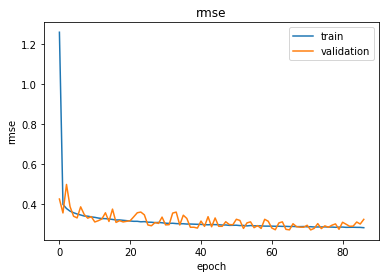

In [16]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

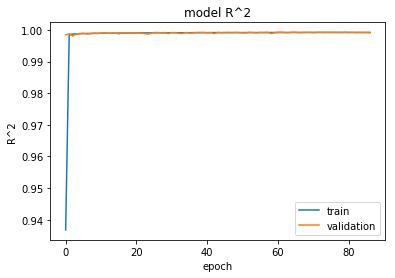

In [17]:
# plot training curve for R^2
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [18]:
import sklearn.metrics as skm, math
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions))



Mean absolute error (MAE):      0.321028
Mean squared error (MSE):       0.227366
Root mean squared error (RMSE): 0.476829
R square (R^2):                 0.999139


## Try dropout

In [19]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model2.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result2 = model2.fit(XX_train, 
                   yy_train,
                   epochs = 100,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0706 19:00:26.179871  3468 deprecation.py:506] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 863855 samples, validate on 215964 samples
Epoch 1/100
863855/863855 [==============================] - 5s 6us/step - loss: 20.4560 - rmse: 1.8398 - r_square: 0.9218 - val_loss: 0.6476 - val_rmse: 0.4984 - val_r_square: 0.9975
Epoch 2/100
863855/863855 [==============================] - 5s 6us/step - loss: 1.5154 - rmse: 0.7344 - r_square: 0.9941 - val_loss: 1.0527 - val_rmse: 0.6566 - val_r_square: 0.9959
Epoch 3/100
863855/863855 [==============================] - 5s 6us/step - loss: 0.9880 - rmse: 0.6105 - r_square: 0.9961 - val_loss: 2.0193 - val_rmse: 0.7998 - val_r_square: 0.9923
Epoch 4/100
863855/863855 [==============================] - 5s 6us/step - loss: 0.7364 - rmse: 0.5351 - r_square: 0.9971 - val_loss: 1.8877 - val_rmse: 0.7485 - val_r_square: 0.9928
Epoch 5/100
863855/863855 [==============================] - 5s 6us/step - loss: 0.5961 - rmse: 0.4862 - r_square: 0.9976 - val_loss: 2.9258 - val_rmse: 0.9831 - val_r_square: 0.9888
Epoch 6/100
863855/863855 [=====

In [21]:
predictions2 = model2.predict(X_test)
print(predictions2[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions2))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions2))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions2)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions2))

[[ 0.96851486]
 [ 6.4468536 ]
 [40.347363  ]
 [11.446528  ]
 [ 1.8761499 ]
 [ 0.12979294]
 [ 4.9536304 ]
 [ 4.142134  ]
 [ 8.117151  ]
 [16.198263  ]]


Mean absolute error (MAE):      1.091110
Mean squared error (MSE):       3.988861
Root mean squared error (RMSE): 1.997213
R square (R^2):                 0.984898


## Try batch normalization technique to regularize neurons

In [24]:
model3 = Sequential([
    BatchNormalization(),
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model3.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result3 = model3.fit(XX_train, 
                   yy_train,
                   epochs = 100,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 863855 samples, validate on 215964 samples
Epoch 1/100
863855/863855 [==============================] - 5s 6us/step - loss: 13.3392 - rmse: 1.6708 - r_square: 0.9485 - val_loss: 0.8619 - val_rmse: 0.6012 - val_r_square: 0.9966
Epoch 2/100
863855/863855 [==============================] - 5s 6us/step - loss: 4.2276 - rmse: 1.1703 - r_square: 0.9835 - val_loss: 0.4646 - val_rmse: 0.4274 - val_r_square: 0.9982
Epoch 3/100
863855/863855 [==============================] - 5s 6us/step - loss: 4.0410 - rmse: 1.1328 - r_square: 0.9842 - val_loss: 0.5685 - val_rmse: 0.4942 - val_r_square: 0.9978
Epoch 4/100
863855/863855 [==============================] - 5s 6us/step - loss: 4.0703 - rmse: 1.1338 - r_square: 0.9840 - val_loss: 0.6028 - val_rmse: 0.5206 - val_r_square: 0.9976
Epoch 5/100
863855/863855 [==============================] - 5s 6us/step - loss: 3.8175 - rmse: 1.0957 - r_square: 0.9851 - val_loss: 0.7584 - val_rmse: 0.5792 - val_r_square: 0.9970
Epoch 6/100
863855/863855 [=====

863855/863855 [==============================] - 5s 6us/step - loss: 3.6306 - rmse: 1.0592 - r_square: 0.9858 - val_loss: 0.3527 - val_rmse: 0.3842 - val_r_square: 0.9986
Epoch 46/100
863855/863855 [==============================] - 5s 6us/step - loss: 3.6800 - rmse: 1.0599 - r_square: 0.9856 - val_loss: 0.4159 - val_rmse: 0.4220 - val_r_square: 0.9984
Epoch 47/100
863855/863855 [==============================] - 5s 6us/step - loss: 3.5382 - rmse: 1.0404 - r_square: 0.9861 - val_loss: 1.0692 - val_rmse: 0.6028 - val_r_square: 0.9959
Epoch 48/100
863855/863855 [==============================] - 5s 5us/step - loss: 3.6088 - rmse: 1.0512 - r_square: 0.9859 - val_loss: 0.3410 - val_rmse: 0.3686 - val_r_square: 0.9987
Epoch 49/100
863855/863855 [==============================] - 5s 5us/step - loss: 3.5764 - rmse: 1.0479 - r_square: 0.9860 - val_loss: 0.7133 - val_rmse: 0.6001 - val_r_square: 0.9972
Epoch 50/100
863855/863855 [==============================] - 5s 6us/step - loss: 3.5432 - rm

In [25]:
predictions3 = model3.predict(X_test)
print(predictions3[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions3))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions3))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions3)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions3))

[[ 0.8519847 ]
 [ 7.147746  ]
 [44.128983  ]
 [12.572897  ]
 [ 2.321763  ]
 [ 0.10606444]
 [ 6.0779285 ]
 [ 4.6703777 ]
 [ 8.171738  ]
 [17.301027  ]]


Mean absolute error (MAE):      0.406705
Mean squared error (MSE):       0.405651
Root mean squared error (RMSE): 0.636908
R square (R^2):                 0.998464


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>